# OpMet Challenge - Performance Metrics for Rotor Classification

Having built a scikit-learn machine learning pipeline, we want to evaluate how well different models are performing.

In [1]:
import pathlib
import datetime
import math
import functools
import numpy
import os

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas

In [3]:
import iris

In [4]:
import matplotlib

In [5]:
%matplotlib inline

In [6]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.neural_network
import sklearn.metrics

In [7]:
try:
    root_data_dir = os.environ['OPMET_DATA_ROOT']
except KeyError:
    root_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
root_data_dir    

'/Users/stephen.haddad/data/ml_challenges/'

## Exploring Falklands Rotor Data

Start by loading the data, seeing what features we have.

In [8]:
falklands_dir = 'Rotors'
falklands_data_path = pathlib.Path(root_data_dir, falklands_dir)

In [9]:
falklands_new_training_data_path = pathlib.Path(falklands_data_path, 'new_training.csv')

In [10]:
falklands_training_df = pandas.read_csv(falklands_new_training_data_path, header=0).loc[1:,:]
falklands_training_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [11]:
falklands_training_df = falklands_training_df.drop_duplicates(subset='DTG')

In [12]:
falklands_training_df.shape

(17507, 95)

### Specify and create input features
Having loaded the data, we then do some preprocessing. This includes:
* Specify feature names
* convert wind speed / direction back to u/v wind. This is because these parameters will vary more smoothly for northerly winds, which is the wind we are interested in.
* prepare the target variable, including filling in missing data.

In [13]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'

In [14]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

In [15]:
falklands_training_df[obs_names]

,air_temp_obs,dewpoint_obs,wind_speed_obs,wind_direction_obs
1,283.9,280.7,4.1,110.0
2,280.7,279.7,7.7,90.0
3,279.8,278.1,7.7,100.0
4,279.9,277.0,7.2,120.0
5,279.9,277.4,8.7,120.0
...,...,...,...,...
20101,276.7,275.5,3.6,270.0
20102,277.9,276.9,3.1,270.0
20103,283.5,277.1,3.6,220.0
20104,286.1,276.9,3.6,250.0


In [16]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [17]:
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/4212466182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/4212466182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')


In [18]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/495145632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/495145632.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')


In [19]:
falklands_training_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,4.714890e-16
3,279.8,278.1,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,-4.350000e+00
...,...,...,...,...
20101,276.7,275.5,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-1.231273e+00


In [20]:
falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
falklands_training_df.loc[falklands_training_df[falklands_training_df['Rotors 1 is true'].isna()].index, target_feature_name] = 0.0
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/2394283915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/2394283915.py:3: 

In [21]:
falklands_training_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors_present, dtype: int64

In [22]:
falklands_training_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'v_wind_19', 'u_wind_20', 'v_wind_20', 'u_wind_21', 'v_wind_21',
       'u_wind_22', 'v_wind_22', 'u_wind_obs', 'v_wind_obs', 'rotors_present'],
      dtype='object', length=142)

### Split into traing/validate/test sets
Next step is to split into train/validate/test sets. We split the pandas data frame, then then later extract the actual training data from the dataframe.

In [23]:
test_fraction = 0.1
validation_fraction = 0.1

In [24]:
num_no_rotors = sum(falklands_training_df[target_feature_name] == False)
num_with_rotors = sum(falklands_training_df[target_feature_name] == True)

In [25]:
data_no_rotors = falklands_training_df[falklands_training_df[target_feature_name] == False]
data_with_rotors = falklands_training_df[falklands_training_df[target_feature_name] == True]

In [26]:
data_test = pandas.concat([data_no_rotors.sample(int(test_fraction * num_no_rotors)), data_with_rotors.sample(int(test_fraction * num_with_rotors))])
data_test[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [27]:
falklands_training_df['test_set'] = False
falklands_training_df.loc[data_test.index,'test_set'] = True

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/1871749377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df['test_set'] = False


In [28]:
data_working = falklands_training_df[falklands_training_df['test_set'] == False]
data_working_no_rotors = data_working[data_working[target_feature_name] == False]
data_working_with_rotors = data_working[data_working[target_feature_name] == True]

In [29]:
data_validation = pandas.concat(
    [data_working_no_rotors.sample(int(validation_fraction * num_no_rotors)), 
     data_working_with_rotors.sample(int(validation_fraction * num_with_rotors))])
falklands_training_df['validation_set'] = False
falklands_training_df.loc[data_validation.index,'validation_set'] = True

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14988/2574544301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df['validation_set'] = False


In [30]:
data_validation[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [31]:
data_train = falklands_training_df[(~falklands_training_df['test_set']) & (~falklands_training_df['validation_set'])]

In [32]:
data_train[target_feature_name].value_counts()

False    13648
True       361
Name: rotors_present, dtype: int64

## Traing and evaluate machine learning models
Having loaded and transformed the data, we do final prrocessing, train several different classifiers representing different classification algorithms, then evaluate performance.


### Preprocess data into input for ML algorithm
The first step is doing the final preprocessing such as tranforming continous features to have zero mean and unit standard deviation.

In [33]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [34]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict[if1] = scaler1

In [35]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(data_train[[target_feature_name]])

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

Apply transformation to each input column

In [36]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [37]:
X_train = preproc_input(data_train, preproc_dict)
y_train = preproc_target(data_train, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


create target feature from rotors

In [38]:
y_train.shape, X_train.shape

((14009,), (14009, 88))

In [39]:
X_val = preproc_input(data_validation, preproc_dict)
y_val = preproc_target(data_validation, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [40]:
X_test = preproc_input(data_test, preproc_dict)
y_test = preproc_target(data_test, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [41]:
train_val_test_tuples = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),    
]

### Train classifiers

At last we are ready to do machine learning! We will try different algorithms, including a tree based methods, ensembles of trees and neural networks.

In [42]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}



In [43]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train, y_train)
    classifiers_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 20min 12s, sys: 19.3 s, total: 20min 31s
Wall time: 5min 20s


### Evaluate classifier perforamnce
Now we take a look at how well our classifiers perform on training and valiation data.

In [47]:
metrics1 = []
for X1, y1 in train_val_test_tuples:
    md1 = {'classifier': [],
           'precision_noRotor': [], 'precision_rotor': [],
           'recall_noRotor': [], 'recall_rotor': [], 
           'f1_noRotor': [], 'f1_rotor': [], 
           'hit_rate': [], 'false_alarm_rate': [],
           'balanced_accuracy': [],
          }
    for clf_name, clf1 in classifiers_dict.items():
        md1['classifier'] += [clf_name]
        prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1)
        md1['precision_noRotor'] += [prec[0]]
        md1['precision_rotor'] += [prec[1]]
        md1['recall_noRotor'] += [recall[0]]
        md1['recall_rotor'] += [recall[1]]
        md1['f1_noRotor'] += [f1[0]]
        md1['f1_rotor'] += [f1[1]]
        ba1 = sklearn.metrics.balanced_accuracy_score(clf1.predict(X1), y1) 
        md1['balanced_accuracy'] += [ba1]
        cm1 = sklearn.metrics.confusion_matrix(clf1.predict(X1), y1)
        hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
        md1['hit_rate'] += [hit_rate]
        false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
        md1['false_alarm_rate'] += [false_alarm_rate]
    metrics1 += [md1]

In [48]:
train_metrics_df = pandas.DataFrame(metrics1[0])
val_metrics_df = pandas.DataFrame(metrics1[1])
test_metrics_df = pandas.DataFrame(metrics1[2])

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

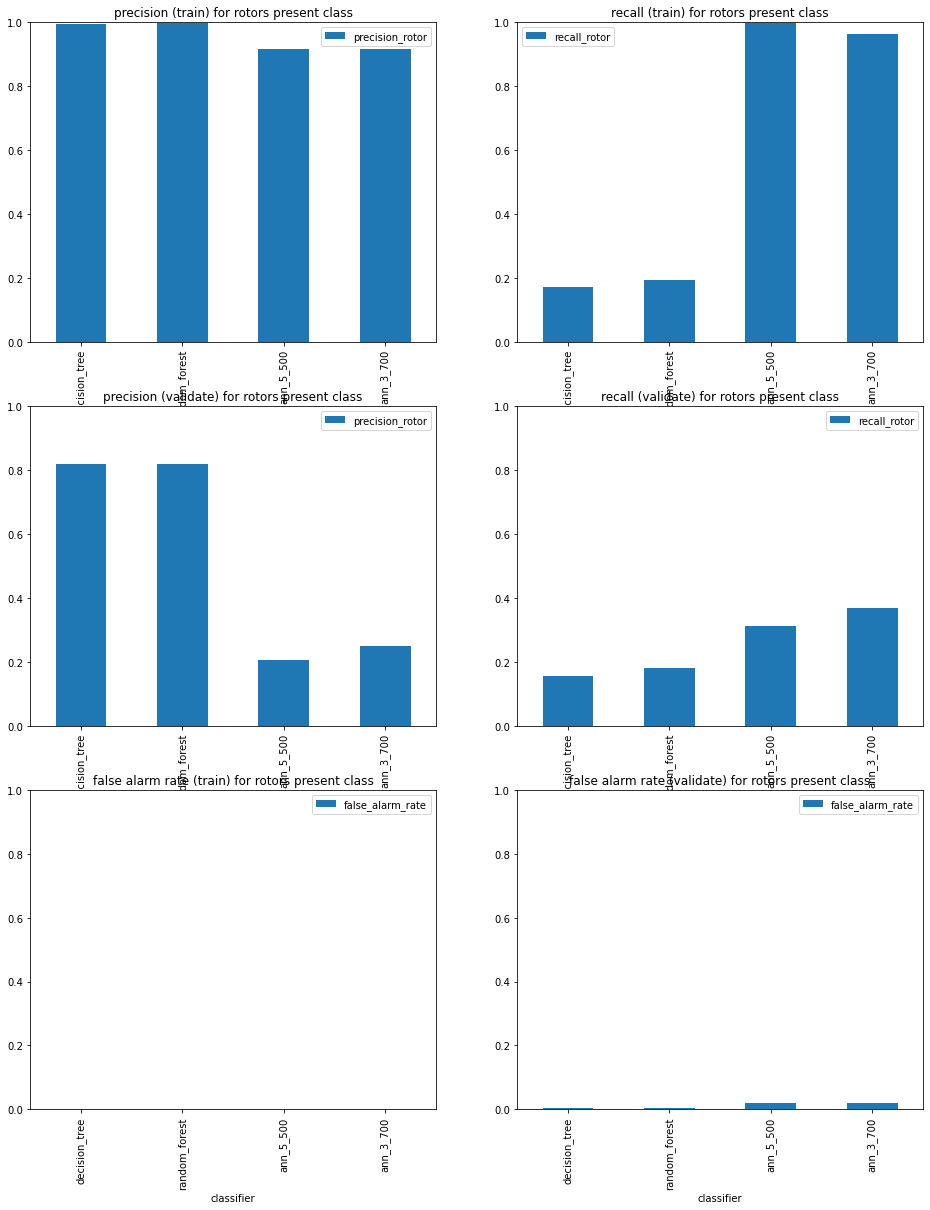

In [49]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
val_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
val_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
val_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [ ]:
data_train_resampled = pandas.concat([
    data_train[data_train[target_feature_name] == True].sample(n=int(1e4), replace=True), 
    data_train[data_train[target_feature_name] == False].sample(n=int(1e4), replace=False),],
    ignore_index=True)

In [ ]:
X_train_resampled = preproc_input(data_train_resampled, preproc_dict)
y_train_resampled = preproc_target(data_train_resampled, target_encoder)

In [ ]:
train_val_test_res_tuples = [
    (X_train_resampled, y_train_resampled),
    (X_val, y_val),
    (X_test, y_test),    
]

In [ ]:
%%time
classifiers_res_dict = {}                    
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train_resampled, y_train_resampled)
    classifiers_res_dict[clf_name] = clf1

In [ ]:
for clf_name, clf1 in classifiers_res_dict.items():
    for X1, y1 in train_val_test_res_tuples:
        print(sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1))


In [ ]:
for clf_name, clf1 in classifiers_res_dict.items():
    for X1, y1 in train_val_test_res_tuples:
        print(sklearn.metrics.balanced_accuracy_score(clf1.predict(X1), y1))    

In [ ]:
for clf_name, clf1 in classifiers_res_dict.items():
    for X1, y1 in train_val_test_res_tuples:
        print(sklearn.metrics.confusion_matrix(clf1.predict(X1), y1))

## Plot SEDI for different classifiers and thresholds

In [50]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [51]:
y_train_pred_raw = classifiers_dict['random_forest'].predict_proba(X_train)[:,1]
y_val_pred_raw = classifiers_dict['random_forest'].predict_proba(X_val)[:,1]
y_test_pred_raw = classifiers_dict['random_forest'].predict_proba(X_test)[:,1]

In [57]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in thresholds_list:
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train, y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

    

In [58]:
numpy.log(hit_rates[1]), numpy.log(false_alarm_rates[1])

(0.0, -1.1404330966078506)

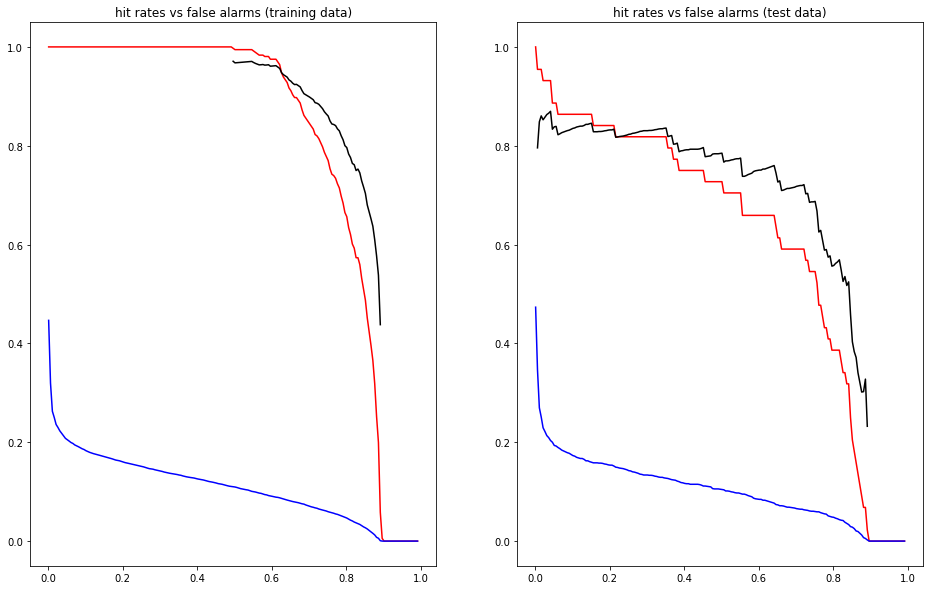

In [59]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

### Conclusions and further work

